<a href="https://colab.research.google.com/github/kakkar87/Obesity-Risk-Analysis-Data-Modeling/blob/main/Unlocking_Insights_%7C_Obesity_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Import Basis
import pandas as pd
from tabulate import tabulate
import optuna
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
# Import necessary libraries
from IPython.display import display, HTML
from scipy.stats import skew  # Import the skew function
# Import Plotly.go
import plotly.graph_objects as go
# import Subplots
from plotly.subplots import make_subplots
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Model Classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler , StandardScaler , QuantileTransformer
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.metrics import *
# Paellete
palette = ["#00B1D2FF", "#FDDB27FF"]
color_palette = sns.color_palette(palette)
# Remove Warnings
import warnings
warnings.filterwarnings("ignore")
# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [8]:
ds = pd.read_csv('/content/drive/MyDrive/colab/obesity_dataset/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/colab/obesity_dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/colab/obesity_dataset/test.csv')
od = pd.read_csv('/content/drive/MyDrive/colab/obesity_dataset/ObesityDataSet_raw_and_data_sinthetic.csv')

In [9]:
# Dropping Id from  Train
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [10]:
train = pd.concat([train, od], axis=0)

In [11]:
def data_overview(train,test):
    print("The Head of the Train Dataset is: ", '\n', tabulate(train.head(),headers='keys', tablefmt='psql'))
    print("The Head of the Test Dataset is: ", '\n', tabulate(test.head(),  headers='keys', tablefmt='psql'))
    print("The Shape of the Train Dataset is: ", train.shape)
    print("The Shape of the Test Dataset is: ", test.shape)
    print("The Info of the Train Dataset is: ", '\n', train.info())
    print("The Info of the Test Dataset is: ", '\n', test.info())
    print("The Numerical Summary of Train is: ", '\n', tabulate(train.describe(),headers='keys', tablefmt='psql'))
    print("The Numerical Summary of Test is: ", '\n', tabulate(test.describe(),headers='keys', tablefmt='psql'))
    print("The Null Values of Train is: ", '\n', train.isnull().sum())
    print("The Null Values of Test is: ", '\n', test.isnull().sum())
    print("Duplicate Values in Train is: ", train.duplicated().sum())
    print("Duplicate Values in Test is: ", test.duplicated().sum())

In [12]:
data_overview(train,test)

The Head of the Train Dataset is:  
 +----+----------+---------+----------+----------+----------------------------------+--------+---------+---------+------------+---------+---------+-------+----------+----------+-----------+-----------------------+---------------------+
|    | Gender   |     Age |   Height |   Weight | family_history_with_overweight   | FAVC   |    FCVC |     NCP | CAEC       | SMOKE   |    CH2O | SCC   |      FAF |      TUE | CALC      | MTRANS                | NObeyesdad          |
|----+----------+---------+----------+----------+----------------------------------+--------+---------+---------+------------+---------+---------+-------+----------+----------+-----------+-----------------------+---------------------|
|  0 | Male     | 24.443  |  1.7     |  81.67   | yes                              | yes    | 2       | 2.9833  | Sometimes  | no      | 2.76357 | no    | 0        | 0.976473 | Sometimes | Public_Transportation | Overweight_Level_II |
|  1 | Female   | 18   

In [13]:
# Data Have No Null Values and Have Some Duplicates
# Drop Duplicates
train.drop_duplicates(inplace=True)

#**`Feature Engineering `**

In [14]:
def feature_engineering(df):
  # Feature 1: BMI (Body Mass Index)
  df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

  # Feature 2: Number of meals per day
  df['Meals_per_day'] = df['FCVC'] + df['NCP']

  # Feature 3: Total physical activity score
  df['Total_activity_score'] = df['FAF'] * df['TUE']

  # Feature 4: Age Category (eg: Young, Adult, Elderly)
  df['Age_Category'] = pd.cut(df['Age'], bins=[0, 18, 60, float('inf')], labels=['Young', 'Adult', 'Elderly'])

  # Feature 5: Water intake per kg of body weight
  df['Water_Intake_Per_Kg'] = df['CH2O'] / df['Weight']

  return df

In [15]:
# Apply feature engineering function to your training and testing datasets
train = feature_engineering(train)
test = feature_engineering(test)

In [16]:
train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Meals_per_day,Total_activity_score,Age_Category,Water_Intake_Per_Kg
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,282595.647630,4.983297,0.000000,Adult,0.033838
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,234220.907298,5.000000,1.000000,Young,0.035088
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,171267.057985,3.292219,1.449399,Young,0.038081
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,448557.984029,6.000000,1.145225,Adult,0.012752
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,255991.509829,4.651136,1.833602,Adult,0.021108


# EDA Analysis

In [17]:
def single_plot_distribution(df, column):
  # Create a figure with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

  # Plot the pie chart on the first subplot
  counts = df[column].value_counts()
  ax1.pie(counts, labels=counts.index, autopct="%1.1f%%")
  ax1.set_title('Distribution of ' + column)

  # Plot the bar chart on the second subplot
  sns.countplot(x=column, data=df, palette=color_palette, dodge=False, ax=ax2)
  ax2.set_xticklabels(rotation=45, labels=ax2.get_xticklabels())
  ax2.set_xlabel(column)
  ax2.set_ylabel('Count')
  ax2.set_title('Counts of ' + column)

  # Show the plot
  plt.show()


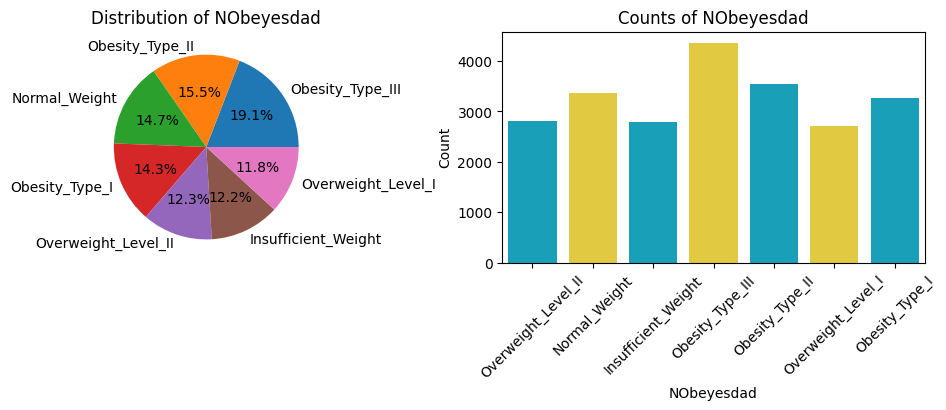

In [18]:
# NObeyesdad Ditribution
single_plot_distribution(train, 'NObeyesdad')

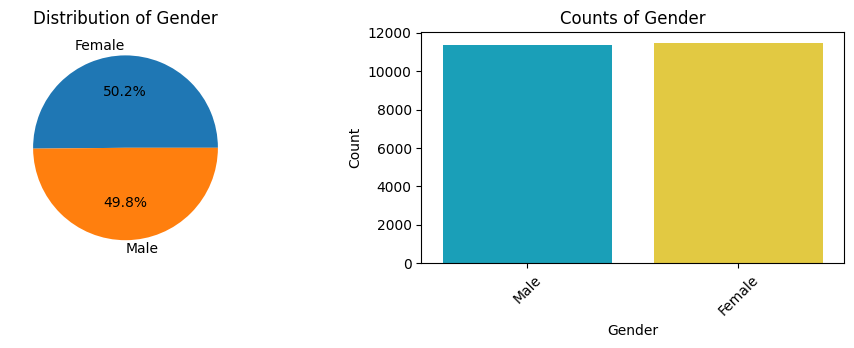

In [19]:
# Gender Ditribution
single_plot_distribution(train, 'Gender')

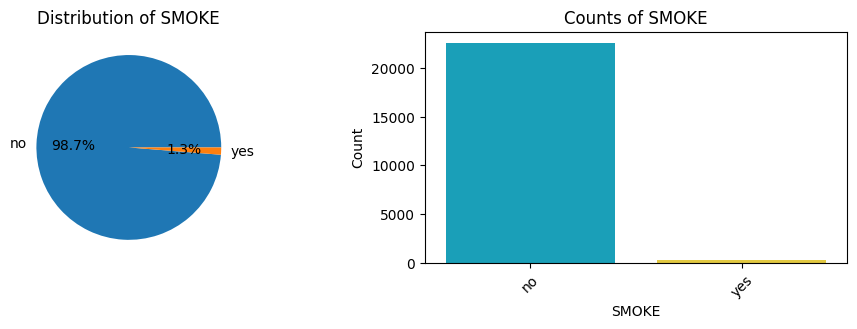

In [20]:
# SMOKE Ditribution
single_plot_distribution(train, 'SMOKE')

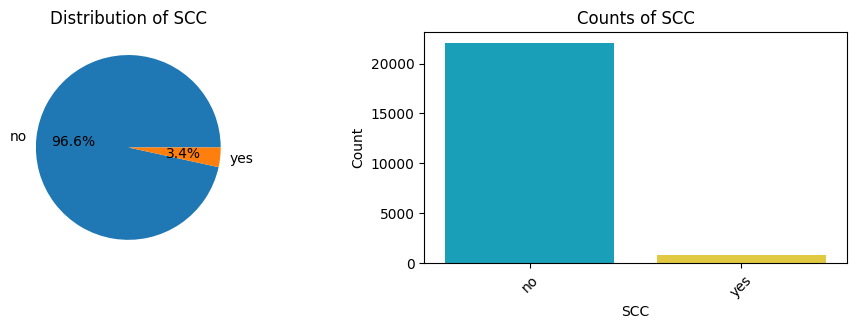

In [21]:
# SCC Ditribution
single_plot_distribution(train, 'SCC')

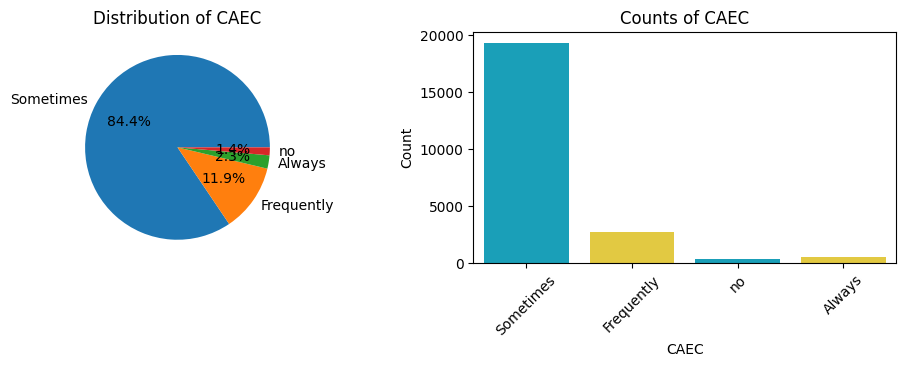

In [22]:
# CAEC Ditribution
single_plot_distribution(train, 'CAEC')

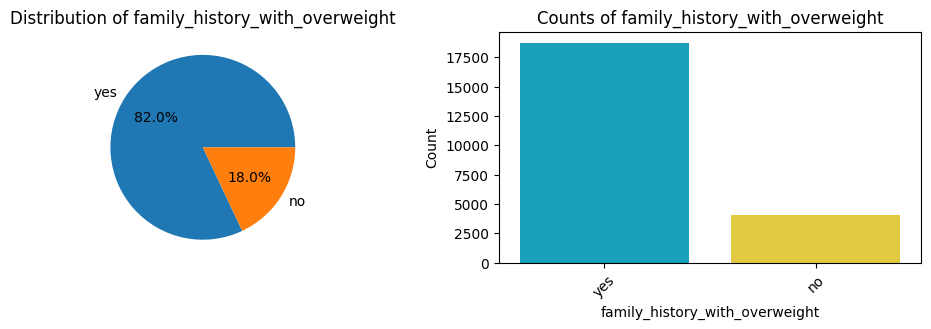

In [23]:
# family_history_with_overweight Ditribution
single_plot_distribution(train,'family_history_with_overweight')

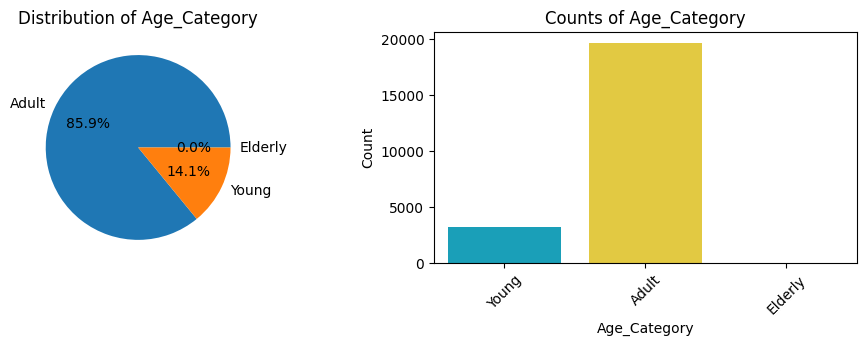

In [24]:
# Age_Category Ditribution
single_plot_distribution(train,'Age_Category')

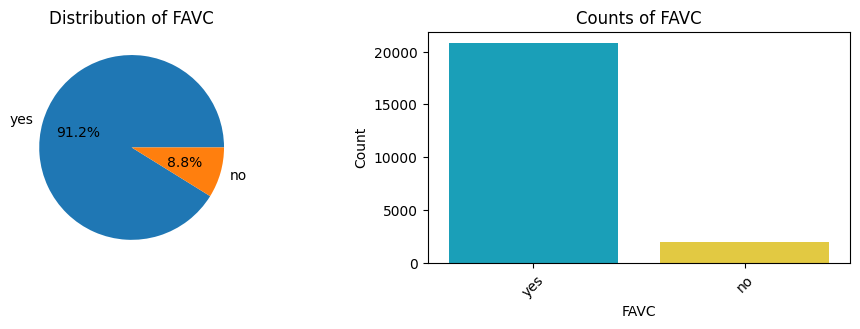

In [25]:
# FAVC Ditribution
single_plot_distribution(train,'FAVC')

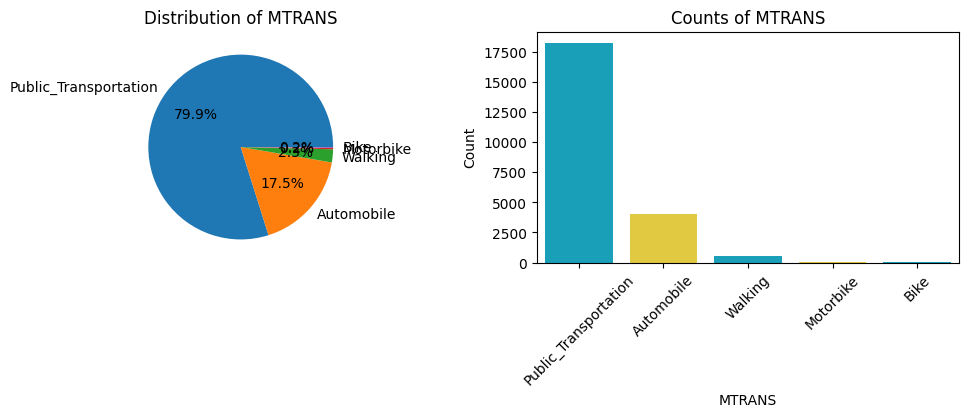

In [26]:
# MTRANS Ditribution
single_plot_distribution(train,'MTRANS')

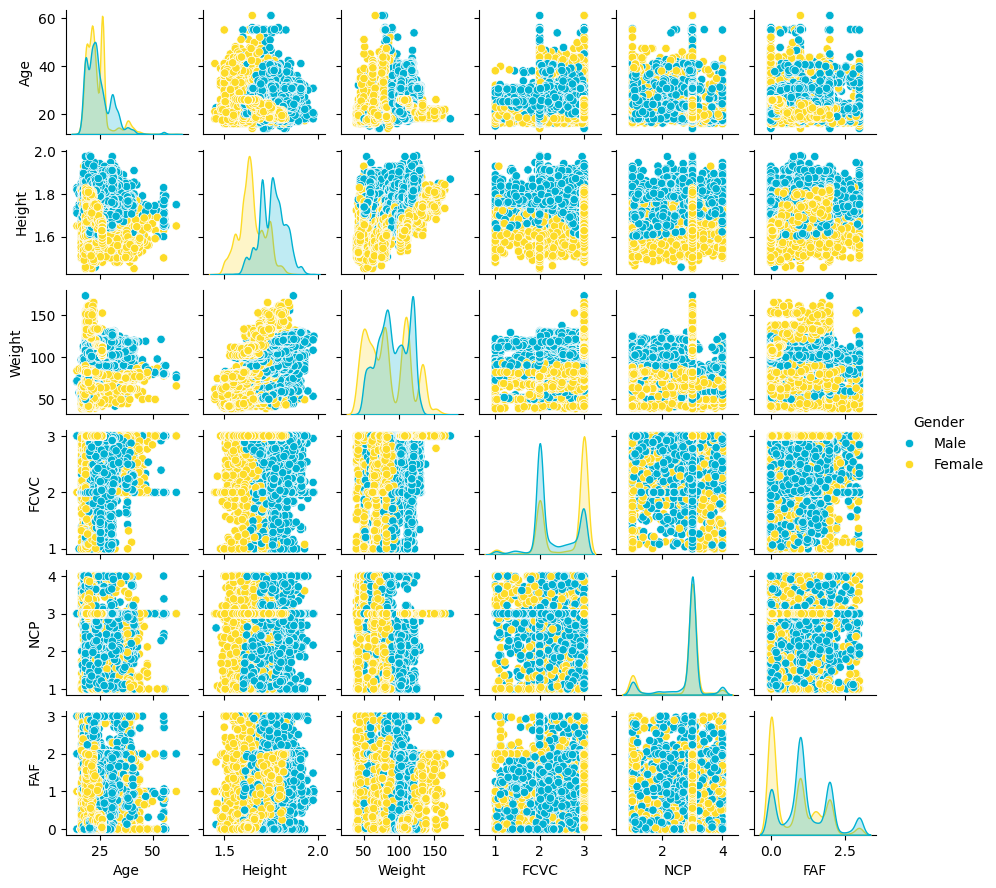

In [27]:
# Columns to plot
columns_to_plot = ['Gender', 'Age', 'Height', 'Weight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'SCC', 'FAF',
       'CALC', 'MTRANS', 'NObeyesdad',
       'Age_Category', ]

# Data Columns
data_to_plot = train[columns_to_plot]

# Create a dictionary to map colors to unique values of the 'Quality' column
Q_colors = {'Male': palette[0], 'Female': palette[1], 'other': 'gray'}

# Creating the pairplot with the specified palette for categorical variables
sns.pairplot(data_to_plot, hue='Gender', palette=Q_colors, height=1.5)
plt.show()

In [28]:
def scatter_plot(x, y, hue, data):
  sns.scatterplot(x=x, y=y, hue=hue, data=data)
  plt.title('Scatter Plot of ' + x + ' vs ' + y + ' Hue by ' + hue)
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

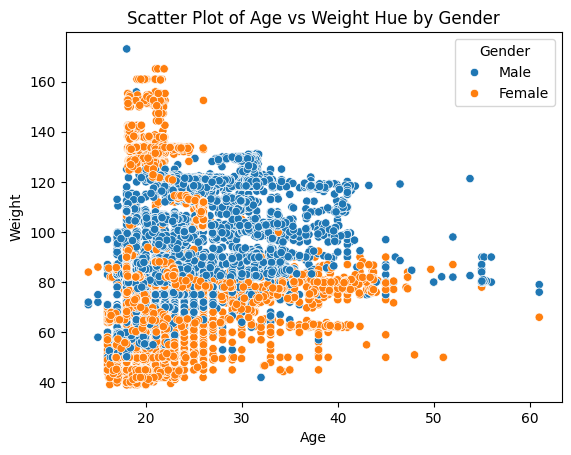

In [29]:
# Scatter Plot | to Show Age vs Weight Realtionship
scatter_plot('Age', 'Weight', 'Gender', train)

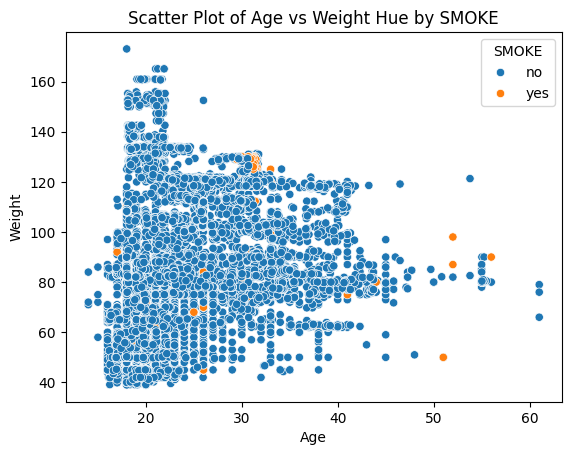

In [30]:
# Scatter Plot | to Show Age vs Weight Realtionship
scatter_plot('Age', 'Weight', 'SMOKE', train)

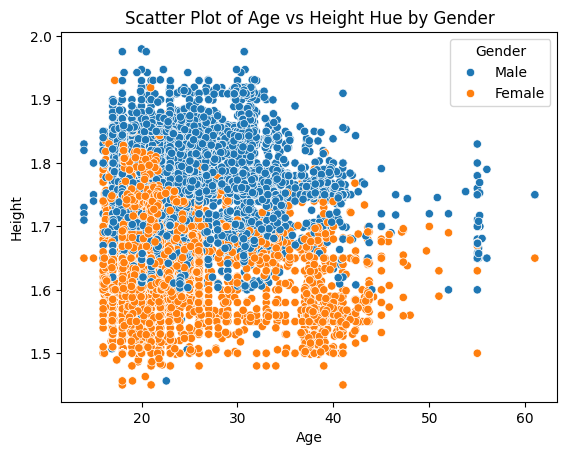

In [31]:
# Scatter Plot | to Show Age vs Height Realtionship
scatter_plot('Age', 'Height', 'Gender', train)

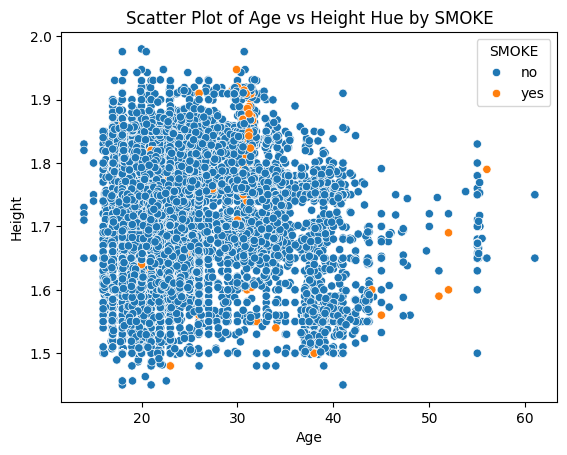

In [32]:
# Scatter Plot | to Show Age vs Height Realtionship
scatter_plot('Age', 'Height', 'SMOKE', train)

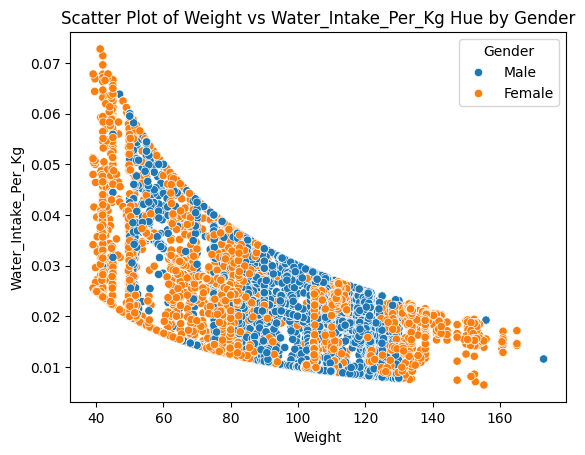

In [33]:
 # Scatter Plot | to Show Weight vs Water_Intake_Per_Kg Realtionship
 scatter_plot('Weight', 'Water_Intake_Per_Kg', 'Gender', train)

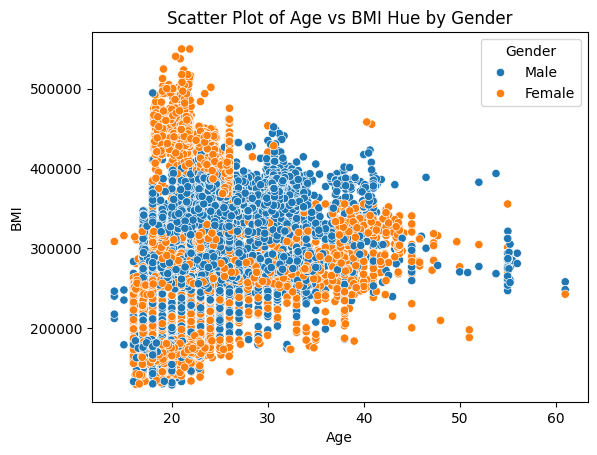

In [34]:
# Scatter Plot | to Show Age vs BMI Realtionship
scatter_plot('Age', 'BMI', 'Gender', train)

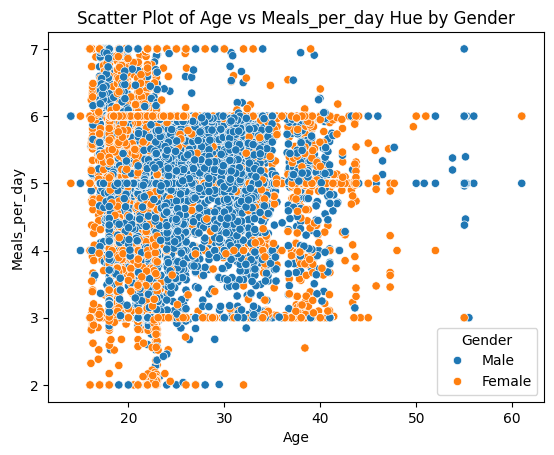

In [35]:
# Scatter Plot | to Show Age vs Meals_Per_Day Realtionship
scatter_plot('Age', 'Meals_per_day', 'Gender', train)

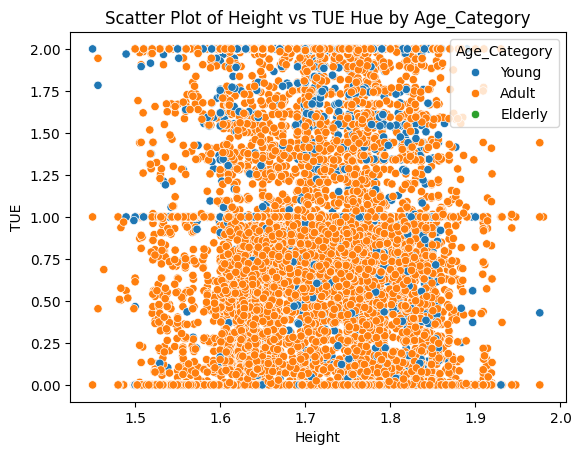

In [36]:
# Scatter Plot | to Show Height vs TUE Realtionship
scatter_plot('Height', 'TUE', 'Age_Category', train)

# Normalization

In [37]:
# Function to Scale Data
def apply_scaling(data, columns, scaler_type):
  # Check the type of scaler and initialize the appropriate scaler object
    if scaler_type == 'S':
        scaler = StandardScaler()  # Initialize StandardScaler
    elif scaler_type == 'M':
        scaler = MinMaxScaler()  # Initialize MinMaxScaler
    elif scaler_type == 'Q':
        scaler = QuantileTransformer(output_distribution='normal')  # Initialize QuantileTransformer
    else:
        raise ValueError("Invalid scaler type. Choose 'S' for StandardScaler, 'M' for MinMaxScaler, or 'Q' for QuantileTransformer.")

    # Create a copy of the input data to avoid modifying the original data
    scaled_data = data.copy()

    # Loop through each column to be scaled
    for col in columns:
        # Apply the scaler to the current column and update the data with the scaled values
        scaled_data[col] = scaler.fit_transform(scaled_data[[col]])

    # Return the scaled data
    return scaled_data

# Specify columns and scaler type
columns_to_scale = [col for col in train.columns if train[col].dtype == 'float']
scaler_type = 'Q'

# Apply scaling to training data
train_scaled = apply_scaling(train, columns_to_scale, scaler_type)
# Apply the same scaling to testing data
test_scaled = apply_scaling(test, columns_to_scale, scaler_type)
print('Data Scaled Done')

Data Scaled Done


# Correlation Analysis

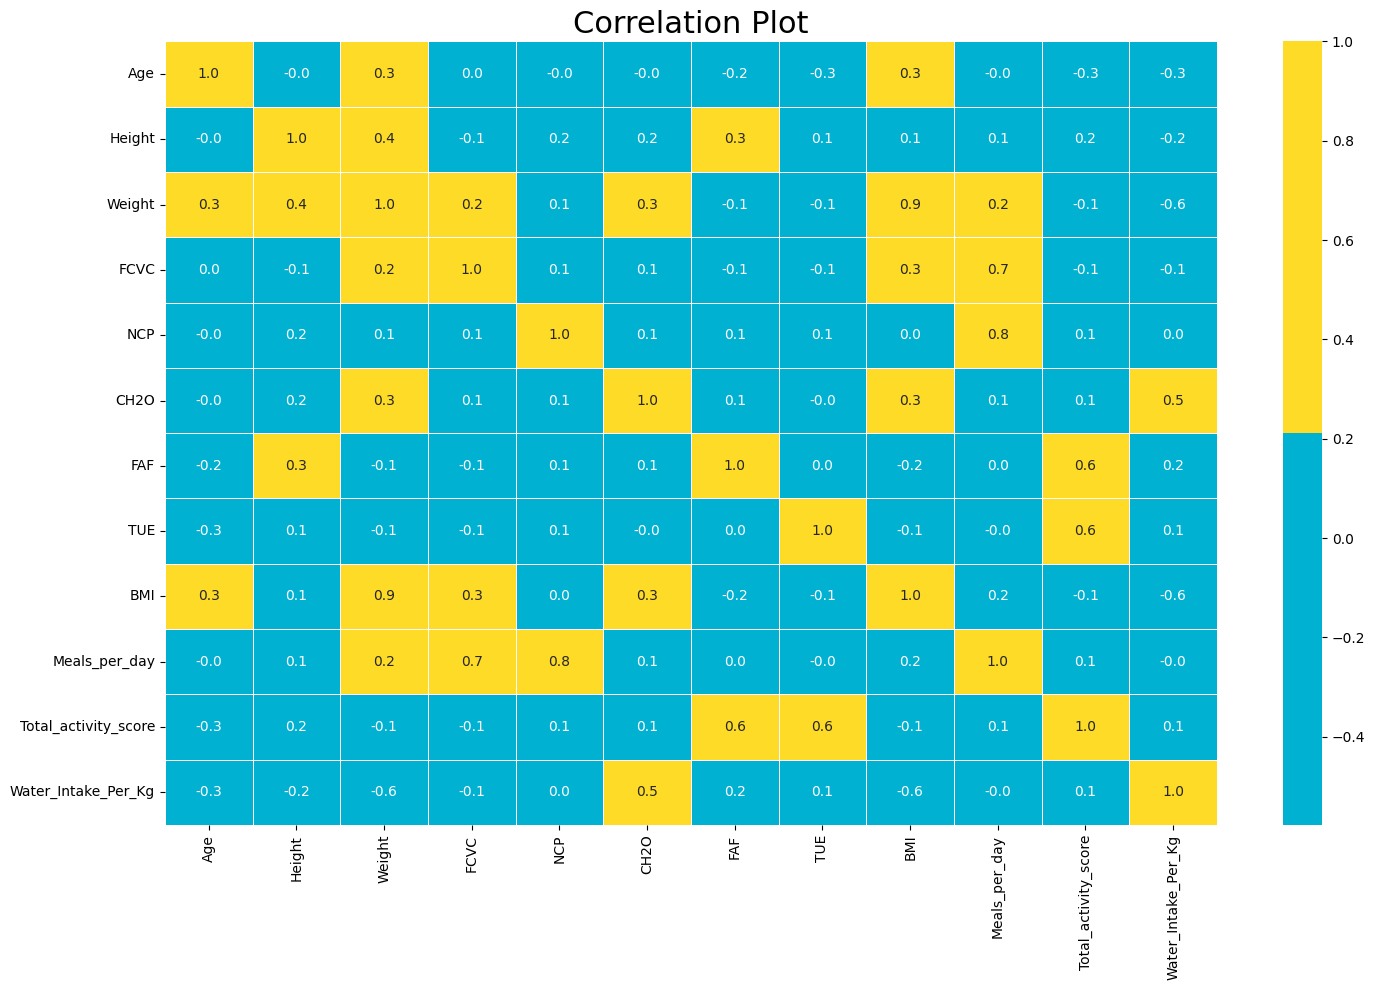

In [38]:
# Select only numeric columns
numeric_data = train.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Create the heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=palette, fmt=".1f", linewidths=0.5)
plt.title('Correlation Plot', fontsize=22)
plt.tight_layout()
plt.show()

# Encoding

In [39]:
print(train.columns)
print(test.columns)

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad', 'BMI', 'Meals_per_day',
       'Total_activity_score', 'Age_Category', 'Water_Intake_Per_Kg'],
      dtype='object')
Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'BMI', 'Meals_per_day', 'Total_activity_score',
       'Age_Category', 'Water_Intake_Per_Kg'],
      dtype='object')


In [40]:
# Encode Train dataset
from sklearn.preprocessing import OneHotEncoder

binary_columns = ['Gender', 'SMOKE','family_history_with_overweight','FAVC','SCC']
encoder = OneHotEncoder(drop='first', sparse=False)
train_encoded = encoder.fit_transform(train[binary_columns])
one_hot_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(binary_columns))

# Drop the original categorical columns
train_e = train.drop(binary_columns, axis=1)

train_e = train_e.reset_index(drop=True)
one_hot_df = one_hot_df.reset_index(drop=True)

# Concatenate the one-hot encoded dataframe with the original dataframe
train_encoded = pd.concat([train_e, one_hot_df], axis=1)

le_category = ['CAEC','CALC','MTRANS','Age_Category']
le=LabelEncoder()
for i in le_category:
  train_encoded[i]=le.fit_transform(train_encoded[i])
  #test[i]=le.fit_transform(test[i])

train_encoded['NObeyesdad']=le.fit_transform(train_encoded['NObeyesdad'])

In [41]:
# Encode Test Dataset
binary_columns = ['Gender', 'SMOKE','family_history_with_overweight','FAVC','SCC']
encoder = OneHotEncoder(drop='first', sparse=False)
test_encoded = encoder.fit_transform(test[binary_columns])
one_hot_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(binary_columns))

# Drop the original categorical columns
test_e = test.drop(binary_columns, axis=1)

test_e = test_e.reset_index(drop=True)
one_hot_df = one_hot_df.reset_index(drop=True)

# Concatenate the one-hot encoded dataframe with the original dataframe
test_encoded = pd.concat([test_e, one_hot_df], axis=1)

le_category = ['CAEC','CALC','MTRANS','Age_Category']
le=LabelEncoder()
for i in le_category:
  test_encoded[i]=le.fit_transform(test_encoded[i])

# Model Building

In [42]:
X_T = train_encoded.drop('NObeyesdad', axis=1)
y_T = train_encoded['NObeyesdad']

In [43]:
X_TR, X_TE, Y_TR, Y_TE = train_test_split(X_T, y_T, test_size=0.1, random_state=42)

In [44]:
print(f"Training set shape - X: {X_TR.shape}, y: {Y_TR.shape}")
print(f"Testing set shape - X: {X_TE.shape}, y: {Y_TE.shape}")

Training set shape - X: (20560, 21), y: (20560,)
Testing set shape - X: (2285, 21), y: (2285,)


# LightGBM *Classifier*
## The Params Used are tunned Using Optuna.

In [46]:
# Use Optuna to tune LightBGM

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 3,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_TR, Y_TR)
    preds = gbm.predict(X_TE)
    accuracy = accuracy_score(Y_TE, preds)
    return accuracy

In [47]:
from optuna.samplers import TPESampler
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-05-09 11:52:51,133] A new study created in memory with name: lightgbm
[I 2024-05-09 11:52:52,918] Trial 0 finished with value: 0.8844638949671773 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 0.8844638949671773.
[I 2024-05-09 11:53:00,372] Trial 1 finished with value: 0.9115973741794311 and parameters: {'lambda_l1': 1.2883876209377052e-05, 'lambda_l2': 3.72312200494449e-05, 'num_leaves': 139, 'feature_fraction': 0.6515167086419769, 'bagging_fraction': 0.8111317002380557, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 1 with value: 0.9115973741794311.
[I 2024-05-09 11:53:05,851] Trial 2 finished with value: 0.9111597374179431 and parameters: {'lambda_l1': 1.763958399884789e-08, 'lambda_l2': 0.010819509974097813, 'num_leaves': 108, 'feature_fraction': 0.7352

In [48]:
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)
print('Best trial:', study.best_trial)

Best parameters: {'lambda_l1': 0.17713458070065588, 'lambda_l2': 3.4872539502018403, 'num_leaves': 21, 'feature_fraction': 0.47485546036584747, 'bagging_fraction': 0.7702966000563878, 'bagging_freq': 6, 'min_child_samples': 42}
Best value: 0.9190371991247265
Best trial: FrozenTrial(number=74, state=TrialState.COMPLETE, values=[0.9190371991247265], datetime_start=datetime.datetime(2024, 5, 9, 11, 58, 43, 949989), datetime_complete=datetime.datetime(2024, 5, 9, 11, 58, 47, 22313), params={'lambda_l1': 0.17713458070065588, 'lambda_l2': 3.4872539502018403, 'num_leaves': 21, 'feature_fraction': 0.47485546036584747, 'bagging_fraction': 0.7702966000563878, 'bagging_freq': 6, 'min_child_samples': 42}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_

In [49]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X_TR, Y_TR)

[LightGBM] [Warning] feature_fraction is set=0.47485546036584747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47485546036584747
[LightGBM] [Warning] lambda_l2 is set=3.4872539502018403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4872539502018403
[LightGBM] [Warning] lambda_l1 is set=0.17713458070065588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17713458070065588
[LightGBM] [Warning] bagging_fraction is set=0.7702966000563878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7702966000563878
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.47485546036584747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47485546036584747
[LightGBM] [Warning] lambda_l2 is set=3.4872539502018403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4872539502018403
[LightGBM] [Warning] lambda_l1

LGBMClassifier(bagging_fraction=0.7702966000563878, bagging_freq=6,
               feature_fraction=0.47485546036584747,
               lambda_l1=0.17713458070065588, lambda_l2=3.4872539502018403,
               min_child_samples=42, num_leaves=21)

In [50]:
# Evaluate the tuned LightGBM model

y_pred = model.predict(X_TE)
accuracy_score(Y_TE, y_pred)
print(classification_report(Y_TE, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.47485546036584747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47485546036584747
[LightGBM] [Warning] lambda_l2 is set=3.4872539502018403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4872539502018403
[LightGBM] [Warning] lambda_l1 is set=0.17713458070065588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17713458070065588
[LightGBM] [Warning] bagging_fraction is set=0.7702966000563878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7702966000563878
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       286
           1       0.90      0.89      0.89       328
           2       0.94      0.89      0.91       352
           3       0.96      0.98      0.97       344
           4       1.00      1.00      1.00      